In [10]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import numpy as np

In [33]:
def load_CIFAR10():
    train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
    test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

    np.set_printoptions(threshold=np.inf)

    X_train = train_dataset.data
    X_test = test_dataset.data

    y_train = np.array(train_dataset.targets)
    y_test = np.array(test_dataset.targets)

    # X_train = np.reshape(X_train, (X_train.shape[0], -1)).T
    # X_test = np.reshape(X_test, (X_test.shape[0], -1)).T

    X_train = X_train.reshape((50000, 32 * 32 * 3)).T
    X_test = X_test.reshape((10000, 32 * 32 * 3)).T

    y_train = y_train.reshape(1, -1)
    y_test = y_test.reshape(1, -1)

    #X_train = X_train[:, :10000]
    #X_test = X_test[:, :1000]

    #y_train = y_train[:10000].reshape(1, -1)
    #y_test = y_test[:1000].reshape(1, -1)

    X_train = X_train.astype("float")
    X_test = X_test.astype("float")

    return X_train, y_train, X_test, y_test


In [34]:
def sorted_distance(X_train, X_test):
    distances = np.zeros((X_test.shape[1], X_train.shape[1]))

    # (X_test - X_train)*(X_test - X_train) = -2X_test*X_train + X_test*X_test + X_train*X_train
    scalar = -2
    d1 = np.multiply(np.dot(X_test.T, X_train), scalar)  # -2 * X_test * X_train
    d2 = np.sum(np.square(X_train), axis=0, keepdims=True)  # X_train * X_train
    d3 = np.sum(np.square(X_test.T), axis=1, keepdims=True)  # X_test * X_test

    distances = np.sqrt(d1 + d2 + d3)

    for i in range(X_test.shape[1]):  # sort the distances row by row
        distances[i] = np.argsort(distances[i])

    return distances


In [35]:
def predict(X_test, X_train, Y_train, k, distances):
    Y_prediction = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        nearest_k = distances[i][:k]  # select k points which have the nearest distance
        nearest_k = nearest_k.astype(np.int64)

        classes_of_k = Y_train[0, nearest_k]  # find the classes of each k points
        Y_prediction[i] = np.argmax(np.bincount(classes_of_k))  # return the class with highest frequency

    return Y_prediction

In [36]:
def knn(X_test, Y_test, X_train, Y_train, k, distances, verbose=False):
    numOftest = Y_test.shape[1]

    Y_prediction = predict(X_test, X_train, Y_train, k, distances)
    num_correct = np.sum(Y_prediction == Y_test)
    accuracy = num_correct / numOftest

    if verbose:
        print('Correct %d/%d: The test accuracy of best k is: %f' % (num_correct, numOftest, accuracy))
    return accuracy

In [37]:
def cross_validation(X_train, y_train, k_set):
    print("-------------------cross validation starts-------------------")
    num_folds = 5    # k-fold value = 5
    best_accuracy = -1
    best_k = 0
    
    # divide both X_train and y_train into 5 parts, 
    # 4 of them are train set and the left one is the test set
    X_train_folds = np.array_split(X_train.T, num_folds)
    y_train_folds = np.array_split(y_train.T, num_folds)

    accuracys = np.zeros(len(k_set), dtype=np.float64)
    
    # Take 4 of them for training, 1 of them for verification by using loop
    for i in range(num_folds):
        X_tr = np.reshape(np.array(X_train_folds[:i] + X_train_folds[i + 1:]),
                          (int(X_train.shape[1] * (num_folds - 1) / num_folds), -1))
        y_tr = np.reshape(y_train_folds[:i] + y_train_folds[i + 1:],
                          (int(y_train.shape[1] * (num_folds - 1) / num_folds), -1))
        X_te = X_train_folds[i]
        y_te = y_train_folds[i]

        distances = sorted_distance(X_tr.T, X_te.T)

        for j in range(len(k_set)):
            accuracys[j] += knn(X_te.T, y_te.T, X_tr.T, y_tr.T, k_set[j], distances, verbose=False)
            # find the best k
            if(accuracys[j] > best_accuracy):
                best_accuracy = accuracys[j]
                best_k = k_set[j]
    # Take the average of all 5 verification results as the accuracy
    accuracys /= num_folds
    
    
    for j in range(len(k_set)):
        print("k =", k_set[j])
        print("the average accuracy of %d train folds is %f" % (num_folds, accuracys[j]))
        print('\n' + "-------------------------------------------------------" + '\n')
      
    # plot the image to show the relationship between k and average accuracy
    plt.plot(k_set, accuracys)
    plt.ylabel('average accuracy')
    plt.xlabel('k')
    plt.title("cross validation on k")
    plt.show()
    print("The best k with highest average accuracy is", best_k)
    return best_k

In [38]:
def test_data_validation(X_test, y_test, X_train, y_train, k):
    print("\n-------------------test data validation starts-------------------")

    # Get the sorted_distance, avoid redundant calculation
    distances = sorted_distance(X_train, X_test)
    print()
    print("The best k we get from the cross validation is", k)
    accuracy = knn(X_test, y_test, X_train, y_train, k, distances, verbose=True)

Files already downloaded and verified
Files already downloaded and verified
-------------------cross validation starts-------------------
k = 3
the average accuracy of 5 train folds is 0.324620

-------------------------------------------------------

k = 5
the average accuracy of 5 train folds is 0.332120

-------------------------------------------------------

k = 7
the average accuracy of 5 train folds is 0.332660

-------------------------------------------------------

k = 11
the average accuracy of 5 train folds is 0.329400

-------------------------------------------------------



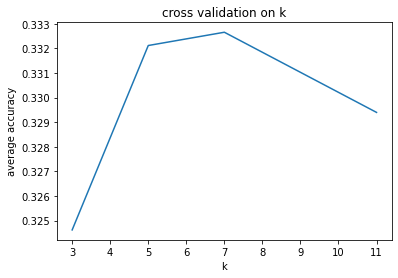

The best k with highest average accuracy is 7

-------------------test data validation starts-------------------

The best k we get from the cross validation is 7
Correct 3358/10000: The test accuracy of best k is: 0.335800


In [39]:
X_train, y_train, X_test, y_test = load_CIFAR10()
k_set = [3, 5, 7, 11]

best_k = cross_validation(X_train, y_train, k_set)
test_data_validation(X_test, y_test, X_train, y_train, best_k)